In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras import layers, models, regularizers

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import os
import winsound
from sklearn.preprocessing import LabelEncoder
import datetime as dt

os.chdir('../scripts')
from functions import impute_immediate_mean
os.chdir('../notebooks')


In [2]:
# Set up alarm for notification of model completion
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

## Read in Data

In [2]:
df_raw =pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)
TSO_preds = df_raw.price_forecast_tomorrow

In [3]:
# Read in data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

## Continuous

In [4]:
df.drop(columns='diff', inplace=True)

#continuous = df.select_dtypes(exclude='object').drop(columns=['price_tomorrow']).columns
continuous = df.select_dtypes(exclude='object').drop(columns=['price_tomorrow', 'price_forecast_tomorrow']).columns

# Get rid of negatives
time = dt.datetime(2021,3,23,22)
df.loc[time, 'dew_point_bilbao'] = impute_immediate_mean(df['dew_point_bilbao'], time)

# Rescale data [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df[continuous] = scaler.fit_transform(df[continuous])

## Categoricals

In [5]:
# Get Categorical columns
categorical = df.select_dtypes(include='object').columns

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in ['wind_madrid', 'wind_seville', 'wind_barcelona', 'wind_bilbao', 'wind_valencia']:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = df.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in df.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

# Rescale data [-1,1]
df[categorical] = scaler.fit_transform(df[categorical])

## Split Data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price_tomorrow'), df['price_tomorrow'], test_size=.3,
                                                    random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=17)

## Neural Network

In [151]:
from sklearn.metrics import mean_absolute_percentage_error

In [208]:
import keras.backend as K
def sMAPE(y_true, y_pred):
    return 100 * K.mean(abs(y_pred - y_true)/((abs(y_true)+abs(y_pred))/2))

In [219]:
def SMAPE(y_true, y_pred):
    return 100/(len(y_true)) * (abs(y_pred - y_true)/((abs(y_true)+abs(y_pred))/2)).sum()

In [211]:
metric = sMAPE
metric.name = 'sMAPE'
print('val_'+metric.name)

val_sMAPE


In [212]:
def split_data(data, val_year):

    # Divide dataset into training and validation
    X_train = data.loc[:str(val_year-1)].drop(columns='price_tomorrow')
    y_train = data.loc[:str(val_year-1), 'price_tomorrow']
    X_val = data.loc[str(val_year)].drop(columns='price_tomorrow')
    y_val = data.loc[str(val_year), 'price_tomorrow']
    return X_train, y_train, X_val, y_val

def compile_fit(nn, X_train, y_train, validation,
                patience=10,
                metric=sMAPE,
                #metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE'),
                loss = tf.keras.metrics.mean_absolute_error,
                batch_size = None):
    
    # Create early stopping point
    metric.name='sMAPE'
    callback = keras.callbacks.EarlyStopping(
        patience=patience,
        monitor='val_'+metric.name,
        mode='min',
        restore_best_weights=True
    )
    # Compile the model
    nn.compile(
        loss=loss, 
        optimizer=keras.optimizers.Adam(),
        metrics=metric
    )
    
    # Fit the model
    history = nn.fit(
        x = X_train,
        y = y_train,
        batch_size=batch_size,
        epochs = 200,
        callbacks=[callback],
        validation_data=validation
    )
    return nn

In [11]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(62, activation='relu', input_shape=(62,)))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))


In [228]:
X_train, y_train, X_val, y_val = split_data(df, 2020)

bl = compile_fit(nn, X_train, y_train, (X_val, y_val),
                patience=10,
                loss = tf.keras.metrics.mean_absolute_error)
preds = bl.predict(X_val).flatten()
r2 = (np.corrcoef(y_val, preds)**2)[0][1]
print('r2:', r2)
print('mape:', mean_absolute_percentage_error(y_val, preds)*100)
print('smape:', SMAPE(y_val, preds))
loss, sMAPE_val = bl.evaluate(X_val, y_val, verbose=0)
print('smape:', sMAPE_val)

Epoch 1/200
1369/1369 [==============================] - 4s 2ms/step - loss: 2.2443 - sMAPE: 4.3627 - val_loss: 5.1662 - val_sMAPE: 17.3103
Epoch 2/200
1369/1369 [==============================] - 3s 2ms/step - loss: 2.2444 - sMAPE: 4.3695 - val_loss: 5.2512 - val_sMAPE: 17.6090
Epoch 3/200
1369/1369 [==============================] - 3s 2ms/step - loss: 2.2510 - sMAPE: 4.3795 - val_loss: 5.2108 - val_sMAPE: 17.3907
Epoch 4/200
1369/1369 [==============================] - 3s 2ms/step - loss: 2.2390 - sMAPE: 4.3562 - val_loss: 5.4151 - val_sMAPE: 18.0029
Epoch 5/200
1369/1369 [==============================] - 3s 2ms/step - loss: 2.2090 - sMAPE: 4.3046 - val_loss: 5.4984 - val_sMAPE: 18.1882
Epoch 6/200
1369/1369 [==============================] - 3s 2ms/step - loss: 2.2168 - sMAPE: 4.3109 - val_loss: 5.1878 - val_sMAPE: 17.3657
Epoch 7/200
1369/1369 [==============================] - 3s 2ms/step - loss: 2.2011 - sMAPE: 4.2800 - val_loss: 5.9701 - val_sMAPE: 19.2752
Epoch 8/200
1369/136

In [222]:
print('r2:', (np.corrcoef(y_val,TSO_preds.loc['2020'])**2)[0][1])
print('mape:', mean_absolute_percentage_error(y_val,TSO_preds.loc['2020'])*100)
print('smape:', SMAPE(y_val,TSO_preds.loc['2020']))

r2: 0.5360771072941372
mape: 18.99661366786526
smape: 13.750704775135429


In [229]:
X_train, y_train, X_test, y_test = split_data(df, 2021)
preds = bl.predict(X_test).flatten()
r2 = (np.corrcoef(y_test, preds)**2)[0][1]
print('r2:', r2)
print('mape:', mean_absolute_percentage_error(y_test, preds)*100)
print('smape:', SMAPE(y_test, preds))
resid_forecast = preds - y_test
resid_forecast

r2: 0.7967657006113489
mape: 312.70000484171294
smape: 33.64966894248505


2021-01-01 00:00:00   -44.781124
2021-01-01 01:00:00   -41.299337
2021-01-01 02:00:00   -38.874764
2021-01-01 03:00:00   -37.799011
2021-01-01 04:00:00   -36.231381
                         ...    
2021-12-30 19:00:00   -54.042716
2021-12-30 20:00:00   -50.105612
2021-12-30 21:00:00   -50.659919
2021-12-30 22:00:00   -36.708922
2021-12-30 23:00:00   -38.334186
Name: price_tomorrow, Length: 8424, dtype: float64

In [289]:
len(y_test)

8424

In [312]:
len(df.loc[df.price_tomorrow==df.price_forecast_tomorrow, ['price_tomorrow', 'price_forecast_tomorrow']])/24

550.2083333333334

In [287]:
TSO_preds.loc['2021'].iloc[300:400].values

array([ 88.75,  88.31,  88.75,  82.87,  88.75,  95.98, 100.17, 103.68,
       107.72, 102.89,  99.05,  95.59,  68.85,  60.  ,  55.48,  54.6 ,
        52.7 ,  54.4 ,  62.97,  77.94,  90.04,  97.76,  90.69,  86.97,
        79.25,  76.64,  77.14,  76.98,  82.  ,  88.22,  98.02,  96.01,
        98.02,  94.29,  84.12,  79.  ,  64.37,  59.91,  55.1 ,  52.2 ,
        52.  ,  52.  ,  53.56,  54.3 ,  61.96,  66.69,  70.09,  69.05,
        68.05,  66.69,  67.54,  65.5 ,  66.69,  70.09,  83.94,  88.82,
        93.79,  89.03,  83.67,  70.24,  66.05,  60.  ,  55.25,  55.  ,
        54.99,  54.99,  54.99,  55.25,  55.68,  59.69,  61.17,  62.4 ,
        63.45,  61.75,  61.69,  55.18,  60.6 ,  67.05,  72.  ,  82.01,
        86.6 ,  87.84,  83.67,  70.97,  81.28,  79.53,  72.05,  70.5 ,
        70.  ,  74.69,  77.84,  80.22,  83.59,  85.66,  83.05,  77.84,
        77.69,  76.59,  73.22,  72.05])

In [309]:
df_2021 = df.loc['2021'].copy()
df_2021.loc[df_2021.price_tomorrow==df_2021.price_forecast_tomorrow, ['price_tomorrow', 'price_forecast_tomorrow']].sort_index()

,price_tomorrow,price_forecast_tomorrow
2021-01-12 00:00:00,74.91,74.91
2021-01-12 01:00:00,72.50,72.50
2021-01-12 02:00:00,65.00,65.00
2021-01-12 03:00:00,63.00,63.00
2021-01-12 04:00:00,61.35,61.35
...,...,...
2021-05-18 19:00:00,85.18,85.18
2021-05-18 20:00:00,89.32,89.32
2021-05-18 21:00:00,90.01,90.01
2021-05-18 22:00:00,87.07,87.07


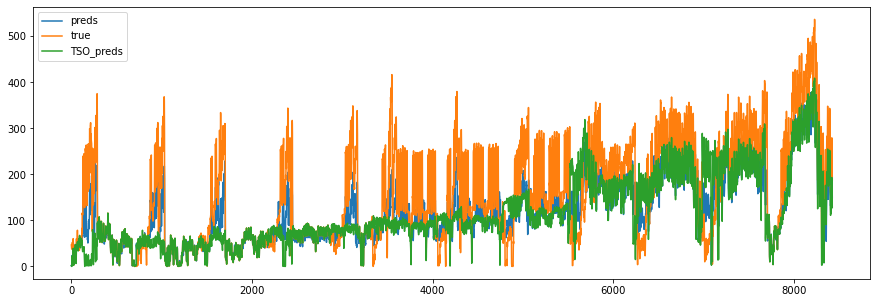

In [290]:
val0 = 0
val = 8424
plt.figure(figsize=(15,5));
plt.plot(preds[val0:val], label='preds');
plt.plot(y_test.iloc[val0:val].values, label='true');
plt.plot(TSO_preds.loc['2021'].iloc[val0:val].values, label='TSO_preds')
plt.legend();


r2: 0.47416317922786577
mape: 461.5627568484001
smape: 42.28441834360905


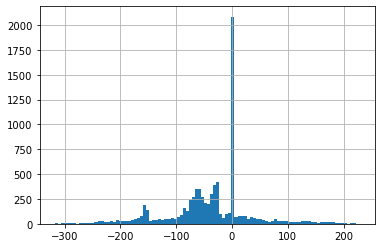

In [224]:
print('r2:', (np.corrcoef(y_test,TSO_preds.loc['2021'])**2)[0][1])
print('mape:', mean_absolute_percentage_error(y_test,TSO_preds.loc['2021'])*100)
print('smape:', SMAPE(y_test,TSO_preds.loc['2021']))
resid_TSO = TSO_preds.loc['2021'] - y_test
resid_TSO.hist(bins=100);

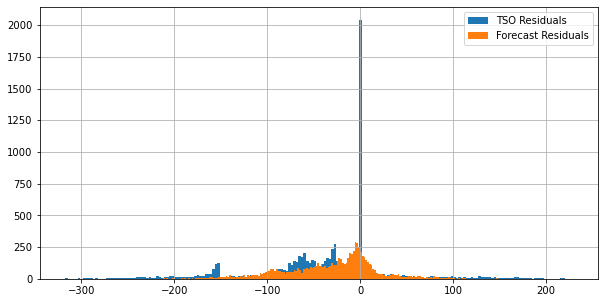

In [145]:
resid_TSO.hist(bins=200, label='TSO Residuals', figsize=(10,5));
resid_forecast.hist(bins=200, label='Forecast Residuals');
plt.legend();

In [135]:
resid_TSO.describe()

count    8424.000000
mean     -153.022191
std       106.154039
min      -535.810000
25%      -243.130506
50%      -127.979255
75%       -61.709216
max        -0.491112
dtype: float64

In [136]:
resid_forecast.describe()

count    8424.000000
mean      -31.131166
std        51.043822
min      -237.427177
25%       -60.414338
50%       -21.210372
75%        -0.454567
max       148.023607
Name: price_tomorrow, dtype: float64

In [60]:
np.array((11,12,13,14,15)).

(5,)

In [87]:
y_preds = np.array([85,85,85,85,85])
y_actual =np.array([60,60,60,60,60])

numerator = np.absolute(y_preds-y_actual)
denominator = (np.absolute(y_actual)+np.absolute(y_preds)) / 2
sum_ = (numerator/denominator).sum()

print(numerator)
print(denominator)
print(sum_)
print(100/(len(y_actual)) * sum_)

[25 25 25 25 25]
[72.5 72.5 72.5 72.5 72.5]
1.7241379310344829
34.48275862068966


In [86]:
SMAPE(y_actual, y_preds)

34.48275862068966

In [37]:
SMAPE(y_test, preds)

-10.519347649814238

In [38]:
SMAPE(y_test, df.loc['2021', 'price_forecast_tomorrow'])

-269.45684502239334

In [ ]:
baseline.predict

In [9]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(239, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
nn.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(learning_rate=.0001),
           metrics=metric)

# Fit the model
history = nn.fit(x= X_train,
                 y=y_train,
                 batch_size=128,
                 epochs = 100,
                 callbacks=[callback],
                 validation_data=(X_val, y_val),
)

preds_train = nn.predict(X_train).flatten()
preds_val = nn.predict(X_val).flatten()

print('r2:',r2_score(y_train, preds_train))
print('r2:',(np.corrcoef(y_train, preds_train)**2)[0][1])

print('val r2:',r2_score(y_val, preds_val))
print('val r2:',(np.corrcoef(y_val, preds_val)**2)[0][1])

Epoch 1/100
334/334 [==============================] - 1s 2ms/step - loss: 42.3649 - MAPE: 83.3904 - val_loss: 24.8675 - val_MAPE: 111.7421
Epoch 2/100
334/334 [==============================] - 1s 2ms/step - loss: 24.3124 - MAPE: 68.8397 - val_loss: 23.3587 - val_MAPE: 100.0323
Epoch 3/100
334/334 [==============================] - 1s 2ms/step - loss: 23.2809 - MAPE: 62.0716 - val_loss: 22.6162 - val_MAPE: 96.2855
Epoch 4/100
334/334 [==============================] - 1s 2ms/step - loss: 22.5349 - MAPE: 60.1233 - val_loss: 21.8751 - val_MAPE: 94.0755
Epoch 5/100
334/334 [==============================] - 1s 2ms/step - loss: 21.7326 - MAPE: 58.6938 - val_loss: 21.1528 - val_MAPE: 95.9708
Epoch 6/100
334/334 [==============================] - 1s 2ms/step - loss: 20.7999 - MAPE: 56.7986 - val_loss: 20.1292 - val_MAPE: 94.3731
Epoch 7/100
334/334 [==============================] - 1s 2ms/step - loss: 19.6020 - MAPE: 55.6993 - val_loss: 18.8427 - val_MAPE: 95.4855
Epoch 8/100
334/334 [====

In [42]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(239, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.L1(.0001)))
nn.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.L1(.0001)))
nn.add(layers.Dense(1, activation='relu'))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
nn.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(learning_rate=.0001),
           metrics=metric)

# Fit the model
history = nn.fit(x= X_train,
                 y=y_train,
                 batch_size=256,
                 epochs = 100,
                 callbacks=[callback],
                 validation_data=(X_val, y_val),
)

preds_train = nn.predict(X_train).flatten()
preds_val = nn.predict(X_val).flatten()

print('r2:',r2_score(y_train, preds_train))
print('r2:',(np.corrcoef(y_train, preds_train)**2)[0][1])

print('val r2:',r2_score(y_val, preds_val))
print('val r2:',(np.corrcoef(y_val, preds_val)**2)[0][1])

Epoch 1/100
167/167 [==============================] - 1s 4ms/step - loss: 40.7536 - MAPE: 82.2737 - val_loss: 29.4587 - val_MAPE: 112.3087
Epoch 2/100
167/167 [==============================] - 0s 3ms/step - loss: 27.4505 - MAPE: 78.2185 - val_loss: 25.6727 - val_MAPE: 95.6277
Epoch 3/100
167/167 [==============================] - 0s 3ms/step - loss: 24.9472 - MAPE: 65.1849 - val_loss: 23.9091 - val_MAPE: 81.0519
Epoch 4/100
167/167 [==============================] - 1s 3ms/step - loss: 23.1896 - MAPE: 55.6207 - val_loss: 22.2045 - val_MAPE: 68.1717
Epoch 5/100
167/167 [==============================] - 0s 3ms/step - loss: 21.1731 - MAPE: 47.3178 - val_loss: 20.1566 - val_MAPE: 54.0342
Epoch 6/100
167/167 [==============================] - 0s 3ms/step - loss: 18.9979 - MAPE: 40.0940 - val_loss: 18.0588 - val_MAPE: 41.6691
Epoch 7/100
167/167 [==============================] - 0s 3ms/step - loss: 16.8930 - MAPE: 35.7444 - val_loss: 16.0439 - val_MAPE: 28.6478
Epoch 8/100
167/167 [=====

## Neural Network - 24 Hour Prediction 
Two hidden layers
### Data Preparation

In [10]:
def to_supervised(train, n_input, n_out=7, stride=1):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :-1])
            y.append(data[in_end:out_end, -1])
        # move along one time step
        in_start += stride
    return np.array(X), np.array(y)

In [11]:
train = df.loc[:'2019'].drop(columns='price_tomorrow')
val = df.loc['2020'].drop(columns='price_tomorrow')

train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train = np.array(np.split(train, len(train)/24))
val = np.array(np.split(val, len(val)/24))
print(train.shape)
print(val.shape)


X_train, y_train = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val, y_val = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train.shape[1], X_train.shape[2])

(1825, 24, 63)
(366, 24, 63)


In [12]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(.0001)))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(.0001)))
bm.add(TimeDistributed(layers.Dense(1)))

Notes:

* <u>monitor_metric & metric (MAPE)</u>:  chosen because sMAPE not available. Chance to hard code sMAPE and implement?
* <u>patience (10)</u>: chosen to prevent reaching local minimum
* <u>loss function (mean_absolute_error)</u>: chosen because as the electricity prices have large spikes, the Euclidean norm would put too much importance on the spiky prices
* 

In [13]:
# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=32,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()


print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
57/57 [==============================] - 1s 7ms/step - loss: 24.9840 - MAPE: 49.5578 - val_loss: 22.3275 - val_MAPE: 101.3881
Epoch 2/100
57/57 [==============================] - 0s 4ms/step - loss: 10.1859 - MAPE: 29.0062 - val_loss: 18.6570 - val_MAPE: 86.8556
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 9.7512 - MAPE: 27.7925 - val_loss: 17.8417 - val_MAPE: 84.4037
Epoch 4/100
57/57 [==============================] - 0s 4ms/step - loss: 9.4841 - MAPE: 27.6586 - val_loss: 15.2118 - val_MAPE: 74.5496
Epoch 5/100
57/57 [==============================] - 0s 4ms/step - loss: 9.3647 - MAPE: 27.4598 - val_loss: 16.4859 - val_MAPE: 79.6707
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 9.1537 - MAPE: 27.3413 - val_loss: 15.6235 - val_MAPE: 76.6590
Epoch 7/100
57/57 [==============================] - 0s 4ms/step - loss: 9.1575 - MAPE: 27.5455 - val_loss: 14.5034 - val_MAPE: 71.9892
Epoch 8/100
57/57 [==========================

In [38]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.9)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.9)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

In [39]:
# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 200,
                 callbacks=[callback],
                 batch_size=512,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/200
4/4 [==============================] - 1s 123ms/step - loss: 3070.5112 - MAPE: 101.8340 - val_loss: 2922.1626 - val_MAPE: 101.8104
Epoch 2/200
4/4 [==============================] - 0s 93ms/step - loss: 2883.5691 - MAPE: 101.3586 - val_loss: 2739.7991 - val_MAPE: 101.1662
Epoch 3/200
4/4 [==============================] - 0s 84ms/step - loss: 2703.2878 - MAPE: 100.7100 - val_loss: 2563.8469 - val_MAPE: 100.5940
Epoch 4/200
4/4 [==============================] - 0s 105ms/step - loss: 2529.2197 - MAPE: 100.2305 - val_loss: 2394.1724 - val_MAPE: 100.0971
Epoch 5/200
4/4 [==============================] - 0s 88ms/step - loss: 2361.3186 - MAPE: 99.6174 - val_loss: 2230.2959 - val_MAPE: 99.6700
Epoch 6/200
4/4 [==============================] - 0s 99ms/step - loss: 2199.3940 - MAPE: 99.2076 - val_loss: 2072.3784 - val_MAPE: 99.3002
Epoch 7/200
4/4 [==============================] - 0s 85ms/step - loss: 2043.2935 - MAPE: 98.9438 - val_loss: 1920.2661 - val_MAPE: 98.9757
Epoch 8/20

In [78]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 36ms/step - loss: 45.4839 - MAPE: 91.9167 - val_loss: 14.1024 - val_MAPE: 66.8014
Epoch 2/100
15/15 [==============================] - 0s 29ms/step - loss: 33.7040 - MAPE: 79.5775 - val_loss: 11.1353 - val_MAPE: 52.1070
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 29.3823 - MAPE: 66.4293 - val_loss: 10.0158 - val_MAPE: 47.2930
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 27.3341 - MAPE: 62.4996 - val_loss: 9.8122 - val_MAPE: 45.6371
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 25.9432 - MAPE: 55.5520 - val_loss: 9.7036 - val_MAPE: 45.2370
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 25.4551 - MAPE: 56.4819 - val_loss: 9.4428 - val_MAPE: 42.3645
Epoch 7/100
15/15 [==============================] - 0s 28ms/step - loss: 24.9479 - MAPE: 53.2063 - val_loss: 9.4181 - val_MAPE: 42.3927
Epoch 8/100
15/15 [===================

In [81]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.001)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 39ms/step - loss: 46.8585 - MAPE: 90.4892 - val_loss: 17.5185 - val_MAPE: 67.1698
Epoch 2/100
15/15 [==============================] - 0s 31ms/step - loss: 36.7941 - MAPE: 79.6642 - val_loss: 13.9950 - val_MAPE: 47.4856
Epoch 3/100
15/15 [==============================] - 0s 29ms/step - loss: 32.5062 - MAPE: 66.7438 - val_loss: 13.3872 - val_MAPE: 48.3413
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 30.4398 - MAPE: 60.3333 - val_loss: 12.8435 - val_MAPE: 44.3023
Epoch 5/100
15/15 [==============================] - 0s 29ms/step - loss: 28.9885 - MAPE: 53.8950 - val_loss: 12.7383 - val_MAPE: 45.2990
Epoch 6/100
15/15 [==============================] - 0s 29ms/step - loss: 28.0770 - MAPE: 54.0073 - val_loss: 12.3631 - val_MAPE: 42.5779
Epoch 7/100
15/15 [==============================] - 0s 31ms/step - loss: 27.3943 - MAPE: 52.5591 - val_loss: 12.2777 - val_MAPE: 43.1760
Epoch 8/100
15/15 [===============

### Limit Price Spikes
Limit price spikes to +- 3*STD

<AxesSubplot:>

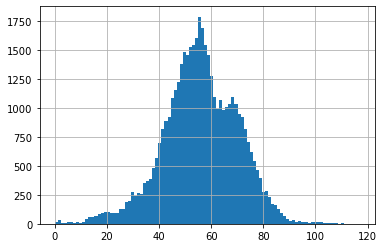

In [86]:
df.loc[:'2019', 'price_tomorrow'].hist(bins=100)

In [87]:
# Get train data, move price column to the end of set
train = df.loc[:'2019'].drop(columns='price_tomorrow')
train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']

# Get price_tomorrow std, mean
price_std = df.loc[:'2019', 'price_tomorrow'].std()
price_mean = df.loc[:'2019', 'price_tomorrow'].mean()

# Copy price data and trim
train_trimmed = train.copy()
train_trimmed.loc[train_trimmed.price_tomorrow>(price_mean + price_std*3), 'price_tomorrow'] = price_mean + price_std*3

# Prep trimmed set for modeling
train_trimmed = np.array(np.split(train_trimmed, len(train_trimmed)/24))
X_train_trimmed, y_train_trimmed = to_supervised(train_trimmed, n_input=24, n_out=24, stride=24)
input_shape=(X_train_trimmed.shape[1], X_train_trimmed.shape[2])

In [89]:
# Instantiate model and build layers
bm_1 = models.Sequential()
bm_1.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.001)))
bm_1.add(layers.Dropout(.9))
bm_1.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
bm_1.add(layers.Dropout(.9))
bm_1.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm_1.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm_1.fit(x= X_train_trimmed,
                 y=y_train_trimmed,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm_1.predict(X_train_trimmed).flatten()
preds_val = bm_1.predict(X_val).flatten()

print('train r2:',r2_score(y_train_trimmed.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 37ms/step - loss: 49.9990 - MAPE: 97.0505 - val_loss: 17.6950 - val_MAPE: 65.8422
Epoch 2/100
15/15 [==============================] - 0s 29ms/step - loss: 37.6961 - MAPE: 78.5583 - val_loss: 14.6209 - val_MAPE: 50.8062
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 33.3626 - MAPE: 66.0142 - val_loss: 13.2559 - val_MAPE: 45.3750
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 30.8016 - MAPE: 60.1920 - val_loss: 12.9144 - val_MAPE: 45.2874
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 29.6809 - MAPE: 57.1782 - val_loss: 12.6283 - val_MAPE: 43.0160
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 28.6406 - MAPE: 54.8142 - val_loss: 12.4827 - val_MAPE: 43.1207
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 27.8335 - MAPE: 51.7723 - val_loss: 12.3108 - val_MAPE: 42.1586
Epoch 8/100
15/15 [===============

Trimming the training response variable did not improve model performance much.

## LSTM - DNN
### DNN

In [92]:
# Get columns representing future information 
DNN_cols = df.filter(regex='forecast').columns

train = df.loc[:'2019', DNN_cols].copy()
val = df.loc['2020', DNN_cols].copy()

train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train = np.array(np.split(train, len(train)/24))
val = np.array(np.split(val, len(val)/24))
print(train.shape)
print(val.shape)


X_train, y_train = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val, y_val = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train.shape[1], X_train.shape[2])
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1825, 24, 7)
(366, 24, 7)
(1824, 24, 6) (1824, 24)
(365, 24, 6) (365, 24)


In [161]:
dnn = keras.Sequential()
dnn.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(.1)))
dnn.add(layers.Dropout(0.9))
dnn.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.1)))
dnn.add(layers.Dropout(0.9))
dnn.add(TimeDistributed(layers.Dense(1)))
# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
dnn.compile(loss=tf.keras.metrics.mean_absolute_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=metric)

# Fit the model
history = dnn.fit(x= X_train,
                  y=y_train,
                  epochs = 100,
                  callbacks=[callback],
                  batch_size=256,
                  validation_data=(X_val, y_val),
)

preds_train = dnn.predict(X_train).flatten()
preds_val = dnn.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
8/8 [==============================] - 1s 58ms/step - loss: 292.8267 - MAPE: 100.9736 - val_loss: 251.7828 - val_MAPE: 99.5367
Epoch 2/100
8/8 [==============================] - 0s 49ms/step - loss: 262.5077 - MAPE: 100.3544 - val_loss: 223.0100 - val_MAPE: 99.0644
Epoch 3/100
8/8 [==============================] - 0s 48ms/step - loss: 234.4179 - MAPE: 99.5702 - val_loss: 196.3035 - val_MAPE: 98.6651
Epoch 4/100
8/8 [==============================] - 0s 43ms/step - loss: 208.4318 - MAPE: 99.2324 - val_loss: 171.6499 - val_MAPE: 98.3157
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 184.5056 - MAPE: 98.9105 - val_loss: 148.9761 - val_MAPE: 97.9587
Epoch 6/100
8/8 [==============================] - 0s 44ms/step - loss: 162.6092 - MAPE: 98.7722 - val_loss: 128.3502 - val_MAPE: 97.5330
Epoch 7/100
8/8 [==============================] - 0s 45ms/step - loss: 142.7926 - MAPE: 98.5376 - val_loss: 109.7376 - val_MAPE: 97.0332
Epoch 8/100
8/8 [===============

### LSTM

In [116]:
# Get columns representing past information 
LSTM_cols = list(set(df.columns) - set(DNN_cols))

train_LSTM = df.loc[:'2019', LSTM_cols].copy()
val_LSTM = df.loc['2020', LSTM_cols].copy()

train_LSTM['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val_LSTM['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train_LSTM = np.array(np.split(train_LSTM, len(train_LSTM)/24))
val_LSTM = np.array(np.split(val_LSTM, len(val_LSTM)/24))
print(train_LSTM.shape)
print(val_LSTM.shape)


X_train_LSTM, y_train_LSTM = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val_LSTM, y_val_LSTM = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])
print(X_train_LSTM.shape, y_train_LSTM.shape)
print(X_val_LSTM.shape, y_val_LSTM.shape)

(1825, 24, 57)
(366, 24, 57)
(1824, 24, 6) (1824, 24)
(365, 24, 6) (365, 24)


In [118]:
y_train_LSTM.shape[1]*7

168

In [107]:
from keras.layers import RepeatVector

In [165]:
lstm = keras.Sequential()
lstm.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
lstm.add(RepeatVector(y_train_LSTM.shape[1]))
lstm.add(layers.Dense(184, activation='relu', kernel_regularizer=regularizers.l1(0.1)))
lstm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
dnn.compile(loss=tf.keras.metrics.mean_absolute_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=metric)

# Fit the model
history = dnn.fit(x= X_train_LSTM,
                  y=y_train_LSTM,
                  epochs = 100,
                  callbacks=[callback],
                  batch_size=128,
                  validation_data=(X_val_LSTM, y_val_LSTM),
)

preds_train = dnn.predict(X_train_LSTM).flatten()
preds_val = dnn.predict(X_val_LSTM).flatten()

print('train r2:',r2_score(y_train_LSTM.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train_LSTM.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val_LSTM.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val_LSTM.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 38ms/step - loss: 26.6459 - MAPE: 48.2963 - val_loss: 14.2966 - val_MAPE: 51.7783
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 25.3086 - MAPE: 45.2933 - val_loss: 13.4928 - val_MAPE: 53.2092
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 24.1907 - MAPE: 46.2159 - val_loss: 13.4061 - val_MAPE: 55.4275
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 23.3549 - MAPE: 46.3062 - val_loss: 13.2973 - val_MAPE: 57.4276
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 22.4916 - MAPE: 46.2195 - val_loss: 13.4286 - val_MAPE: 59.3083
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 21.9316 - MAPE: 45.3119 - val_loss: 13.7680 - val_MAPE: 61.9331
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 21.4020 - MAPE: 44.5079 - val_loss: 13.7720 - val_MAPE: 63.9574
Epoch 8/100
15/15 [===============

In [125]:
np.corrcoef(df['price_forecast_tomorrow'].values, df.price_tomorrow)**2

array([[1.        , 0.48064142],
       [0.48064142, 1.        ]])

### Ensemble LSTM-DNN Model

## GRU - DNN

## CNN